In [1]:
import pandas as pd
import numpy as np
import os
import pymc as pm
import arviz as az
import scipy.stats as ss
from datetime import datetime
from turf import scrape, utils, inference
import turf

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

**Initiate and fit model**

---


In [2]:
# Pull results
season = scrape.Season(year=2023, week=None)

/Users/davidfleming/turf/turf/scrape.py:133: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df = pd.read_html(url, parse_dates=True, attrs={'id': 'games'},


In [3]:
# Initialize model
model = inference.CorrelatedPoisson(season)

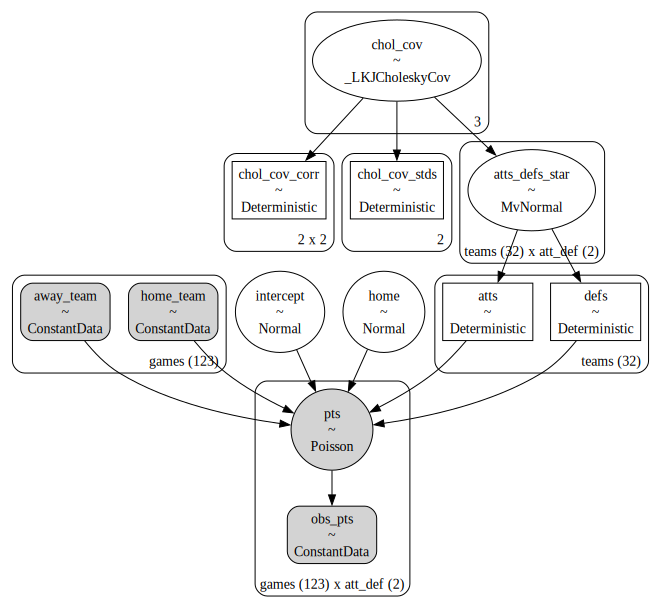

In [4]:
# Visualize model
pm.model_graph.model_to_graphviz(model.model)

In [5]:
# Run inference
model.run_inference(tune=1000, draws=1000, target_accept=0.9, chains=4)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [home, intercept, chol_cov, atts_defs_star]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 15 seconds.


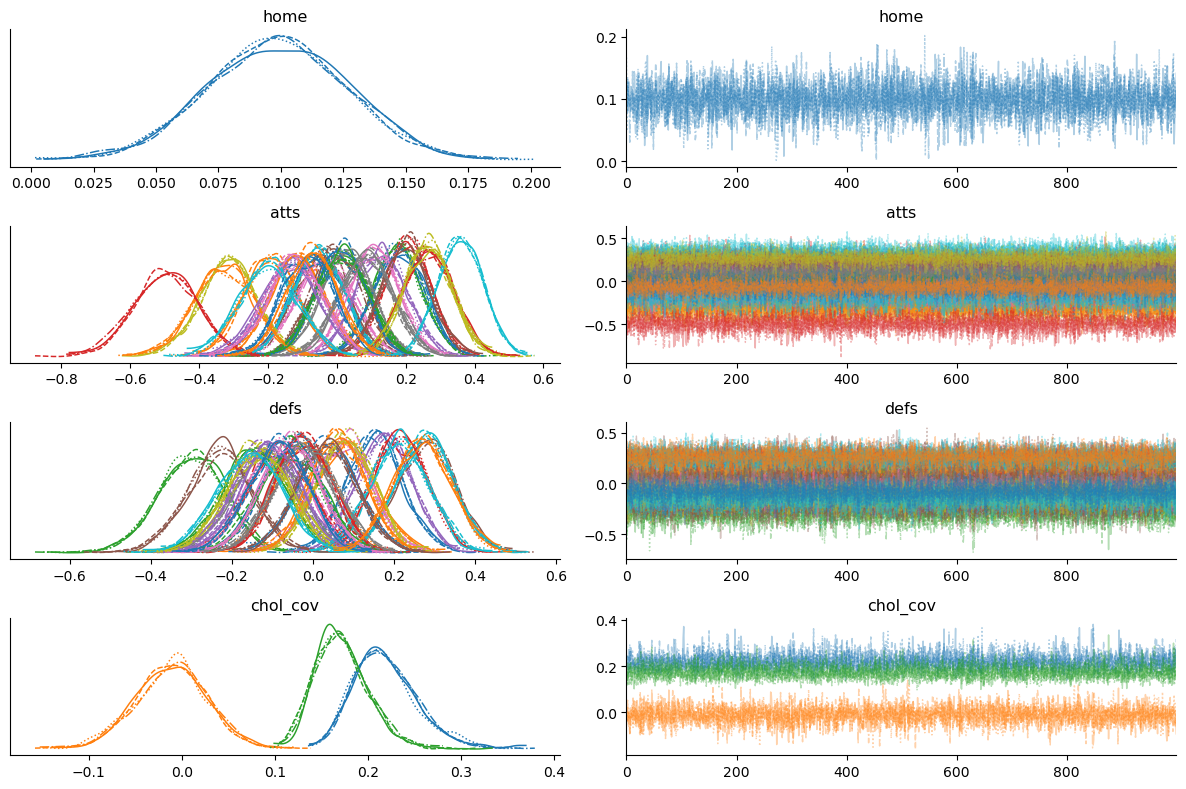

In [6]:
axes = az.plot_trace(model.trace_, compact=True, var_names=["home", "atts", "defs", "chol_cov"])

for ii in range(axes.shape[0]):
    for jj in range(axes.shape[1]):
        ax = axes[ii,jj]
        sns.despine(ax=ax)
ax.get_figure().tight_layout()

In [7]:
az.summary(model.trace_, group='posterior', var_names=['att'], filter_vars='like')

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
"atts_defs_star[ARZ, att]",-0.058,0.087,-0.226,0.099,0.001,0.001,3800.0,3113.0,1.0
"atts_defs_star[ARZ, def]",0.154,0.076,0.008,0.294,0.001,0.001,4509.0,3167.0,1.0
"atts_defs_star[ATL, att]",-0.194,0.088,-0.367,-0.034,0.001,0.001,3838.0,3035.0,1.0
"atts_defs_star[ATL, def]",-0.020,0.078,-0.164,0.129,0.001,0.001,5124.0,3246.0,1.0
"atts_defs_star[BLT, att]",0.175,0.081,0.028,0.330,0.001,0.001,3108.0,3019.0,1.0
...,...,...,...,...,...,...,...,...,...
atts[SEA],0.086,0.077,-0.048,0.237,0.001,0.001,7405.0,3096.0,1.0
atts[SF],0.265,0.069,0.136,0.396,0.001,0.001,6817.0,3299.0,1.0
atts[TB],-0.200,0.085,-0.368,-0.047,0.001,0.001,8156.0,3341.0,1.0
atts[TEN],-0.084,0.079,-0.222,0.073,0.001,0.001,7804.0,2778.0,1.0


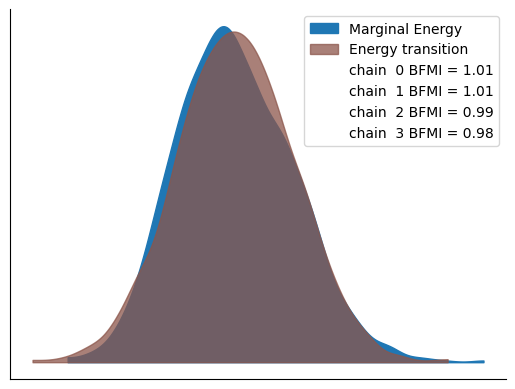

In [8]:
ax = az.plot_energy(model.trace_)
sns.despine(ax=ax)

In [9]:
# Team names, medians, CIs, and colors
team_names = model.trace_.posterior.coords['teams'].values

# Calculate median, 68% CI for atts, defs for each team
med_atts = model.trace_.posterior["atts"].median(axis=1).median(axis=0).values
med_defs = model.trace_.posterior["defs"].median(axis=1).median(axis=0).values

# Calculate median, 68% CI for atts, defs for each team, convert to numpy arrays
defs_CI = az.hdi(model.trace_, var_names=["defs"], hdi_prob=0.68)
defs_CI = defs_CI.to_array().values[0]

atts_CI = az.hdi(model.trace_, var_names=["atts"], hdi_prob=0.68)
atts_CI = atts_CI.to_array().values[0]

# Get primary and secondary colors
pri_colors = list(map(lambda x : turf.utils._hex_color[f"{x}_0"], team_names))
sec_colors = list(map(lambda x : turf.utils._hex_color[f"{x}_1"], team_names))

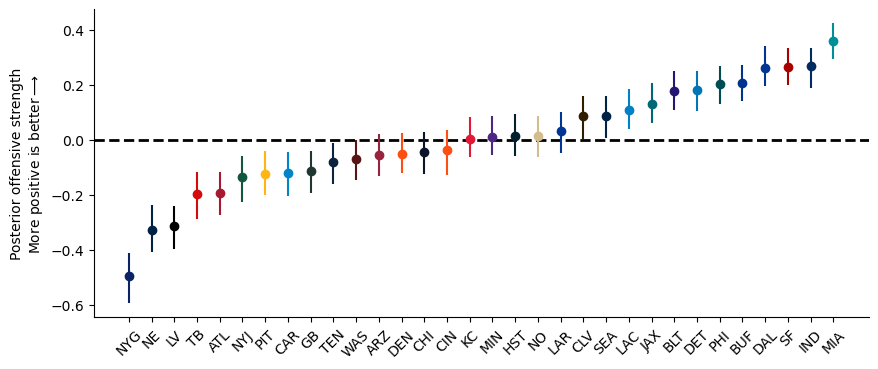

In [10]:
# Plot ordered attacking strength
fig, ax = plt.subplots(figsize=(10,4))

# Order values by worst to best attacking
inds = np.argsort(med_atts)

x = np.arange(len(med_atts))
for ii in range(len(x)):
    ax.errorbar(x[ii], med_atts[inds[ii]], 
                yerr=np.asarray([med_atts[inds[ii]] - atts_CI[inds[ii],0], atts_CI[inds[ii],1] - med_atts[inds[ii]]]).reshape(2,1),
                fmt='o', color=pri_colors[inds[ii]])

ax.axhline(0, lw=2, ls="--", color="k", zorder=0)
ax.set_xlabel('')
ax.set_ylabel('Posterior offensive strength\nMore positive is better$\longrightarrow$')
_ = ax.set_xticks(x)
_ = ax.set_xticklabels(model._coords["teams"][inds], rotation=45)
sns.despine(ax=ax)

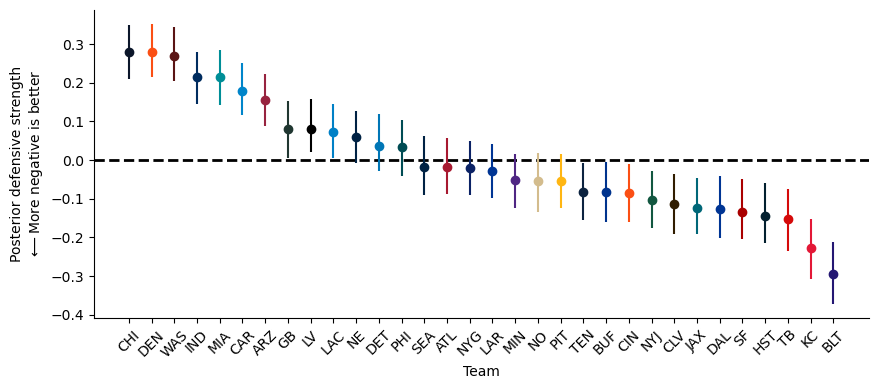

In [11]:
# Plot ordered attacking strength
fig, ax = plt.subplots(figsize=(10,4))

# Order values by worst to best attacking
inds = np.argsort(med_defs)[::-1]

x = np.arange(len(med_defs))
for ii in range(len(x)):
    ax.errorbar(x[ii], med_defs[inds[ii]], 
                yerr=np.asarray([med_defs[inds[ii]] - defs_CI[inds[ii],0], defs_CI[inds[ii],1] - med_defs[inds[ii]]]).reshape(2,1),
                fmt='o', color=pri_colors[inds[ii]])

ax.axhline(0, lw=2, ls="--", color="k", zorder=0)
ax.set_xlabel('Team')
ax.set_ylabel('Posterior defensive strength\n$\longleftarrow$More negative is better')
_ = ax.set_xticks(x)
_ = ax.set_xticklabels(model._coords["teams"][inds], rotation=45)
sns.despine(ax=ax)

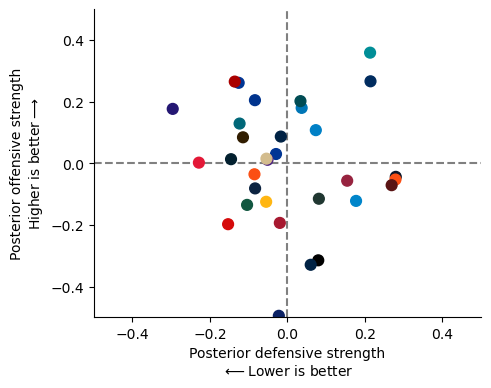

In [12]:
fig, ax = plt.subplots(figsize=(5,4))

im = ax.scatter(med_defs, med_atts, s=60, zorder=1, c=pri_colors)
ax.axhline(0, lw=1.5, ls="--", color="grey", zorder=0)
ax.axvline(0, lw=1.5, ls="--", color="grey", zorder=0)

ax.set_xlabel('Posterior defensive strength\n$\longleftarrow$Lower is better')
ax.set_ylabel('Posterior offensive strength\nHigher is better$\longrightarrow$')
ax.set_xlim(-0.5, 0.5)
ax.set_ylim(-0.5, 0.5)
sns.despine(ax=ax)

**Simulate many games**

---

And summarize the results

In [14]:
away_teams = ["SEA", "WAS", "TB", "CHI", "ARZ", "MIN", "LAR", "IND", "NYG", "DAL", "BUF"]
home_teams = ["BLT", "NE", "HST", "NO", "CLV", "ATL", "GB", "CAR", "LV", "PHI", "CIN"]
ous = [45, 40.5, 40, 42, 38, 39, 37.5, 44.5, 38, 46.5, 50.5]
home_spread = [-6.5, -3, -2.5, -9.5, -12.5, -3.5, -3.5, 2, -2, -3, -2.5]

for home_team, away_team, ou, hs, ii, in zip(home_teams, away_teams, ous, home_spread, np.arange(len(home_teams))):

    home_pts, away_pts, home_win, tie = model.simulate_game(home_team, away_team, n=10000, seed=None)
    
    total = home_pts + away_pts
    odds = np.mean(total > ou)
    cover = np.mean(home_pts - away_pts > -hs)
    home_ml = np.mean(home_pts > away_pts)
    
    print(f"---{away_team} at {home_team}---")
    print(f"O/U: {ou} - Over odds : {np.round(100*odds, decimals=2):.2f}%")
    print(f"Spread: {home_team} {home_spread[ii]} - odds of {home_team} cover : {np.round(100*cover, decimals=2):.2f}%") 
    print(f"ML: - odds of {home_team} ML : {np.round(100*home_ml, decimals=2):.2f}%")
    print(f"Median outcome: {away_team} {np.median(away_pts):.0f} | {home_team} {np.median(home_pts):.0f}")
    print()

---SEA at BLT---
O/U: 45 - Over odds : 31.41%
Spread: BLT -6.5 - odds of BLT cover : 66.62%
ML: - odds of BLT ML : 90.04%
Median outcome: SEA 16 | BLT 26

---WAS at NE---
O/U: 40.5 - Over odds : 49.46%
Spread: NE -3 - odds of NE cover : 35.91%
ML: - odds of NE ML : 52.75%
Median outcome: WAS 20 | NE 21

---TB at HST---
O/U: 40 - Over odds : 14.46%
Spread: HST -2.5 - odds of HST cover : 64.40%
ML: - odds of HST ML : 75.52%
Median outcome: TB 14 | HST 19

---CHI at NO---
O/U: 42 - Over odds : 74.97%
Spread: NO -9.5 - odds of NO cover : 59.48%
ML: - odds of NO ML : 92.02%
Median outcome: CHI 18 | NO 29

---ARZ at CLV---
O/U: 38 - Over odds : 81.13%
Spread: CLV -12.5 - odds of CLV cover : 41.16%
ML: - odds of CLV ML : 92.01%
Median outcome: ARZ 17 | CLV 28

---MIN at ATL---
O/U: 39 - Over odds : 35.60%
Spread: ATL -3.5 - odds of ATL cover : 18.16%
ML: - odds of ATL ML : 31.66%
Median outcome: MIN 20 | ATL 17

---LAR at GB---
O/U: 37.5 - Over odds : 70.53%
Spread: GB -3.5 - odds of GB cover

**Examine individual game**

---

/Users/davidfleming/mambaforge/envs/pymc_env/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/davidfleming/mambaforge/envs/pymc_env/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/davidfleming/mambaforge/envs/pymc_env/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/davidfleming/mambaforge/envs/pymc_env/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na 

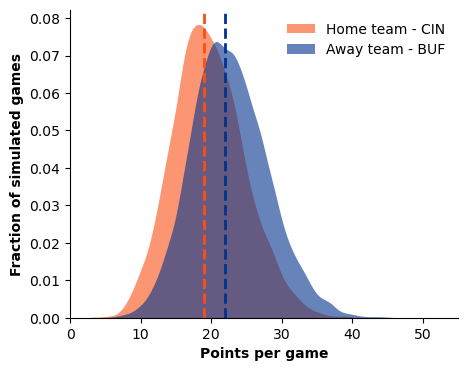

In [15]:
fig, ax = plt.subplots(figsize=(5,4))

pal = sns.color_palette('crest')
home_color = turf.utils._hex_color[f"{home_team}_0"]
away_color = turf.utils._hex_color[f"{away_team}_0"]
sns.kdeplot(x=home_pts, color=home_color, fill='true',  label=f"Home team - {home_team}", lw=0, alpha=0.6, cut=0)
sns.kdeplot(x=away_pts, color=away_color, fill='true', label=f"Away team - {away_team}", lw=0, alpha=0.6, cut=0)

ax.axvline(np.median(home_pts), lw=2, color=home_color, ls="--")
ax.axvline(np.median(away_pts), lw=2, color=away_color, ls="--")

ax.legend(loc="best", framealpha=0)
ax.set_xlim(0, 55)
ax.set_ylabel("Fraction of simulated games", weight="bold")
ax.set_xlabel("Points per game", weight="bold")
sns.despine(ax=ax)

/Users/davidfleming/mambaforge/envs/pymc_env/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/davidfleming/mambaforge/envs/pymc_env/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/davidfleming/mambaforge/envs/pymc_env/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/davidfleming/mambaforge/envs/pymc_env/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na 

PearsonRResult(statistic=-0.007767367157578586, pvalue=0.43736450719411907)


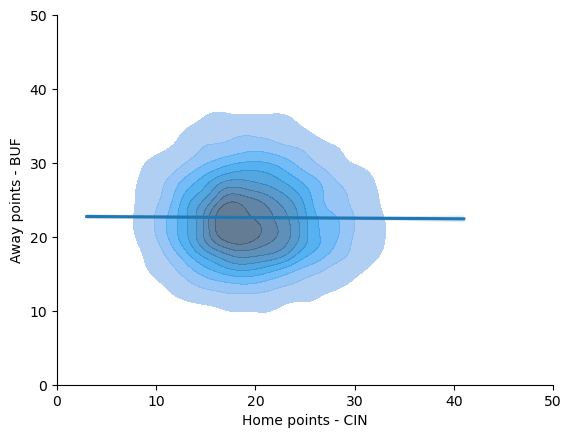

In [16]:
ax = sns.kdeplot(x=home_pts, y=away_pts, color="C0", fill='true',  lw=0, alpha=0.8, cut=0)
sns.regplot(x=home_pts, y=away_pts, scatter=False, ax=ax);
print(ss.pearsonr(home_pts, away_pts))

ax.set_xlabel(f"Home points - {home_team}")
ax.set_ylabel(f"Away points - {away_team}")
ax.set_xlim(0, 50)
ax.set_ylim(0, 50)
sns.despine(ax=ax);

**Examine posterior predictive distribution**

---

Simple model evaluation method

In [17]:
# Sample from posterior predictive distribution
with model.model:
    model.trace_.extend(pm.sample_posterior_predictive(model.trace_))

Sampling: [pts]


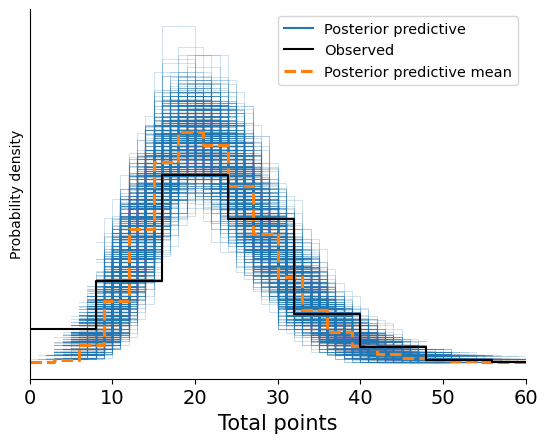

In [18]:
ax = az.plot_ppc(model.trace_, kind='kde', num_pp_samples=1000, group='posterior')
sns.despine(ax=ax)
ax.set_xlim(0, 60)
ax.set_xlabel("Total points")
ax.set_ylabel("Probability density");